# Feature Selection

## Imports and preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'


In [4]:
from preprocessing import preprocess_all_columns

X_train, X_test, y_train, y_test = preprocess_all_columns()

In [5]:
## HOW TO GET 9.0 and 7.0 COLUMN NAMES:
X_train.filter(regex='_9\.0$').columns
X_train.filter(regex='_7\.0$').columns

Index(['RATCAT_A_7.0', 'HISPALLP_A_7.0', 'RACEALLP_A_7.0', 'CITZNSTP_A_7.0',
       'SPOUSEDUCP_A_7.0', 'MARSTAT_A_7.0', 'SPOUSWRK_A_7.0',
       'PCNTADWFP1_A_7.0', 'PCNTADWKP1_A_7.0', 'EMPWRKFT1_A_7.0',
       ...
       'STREV_A_7.0', 'MIEV_A_7.0', 'ANGEV_A_7.0', 'CHDEV_A_7.0',
       'CHLEV_A_7.0', 'HYPEV_A_7.0', 'LSATIS4_A_7.0', 'PHSTAT_A_7.0',
       'AVAIL_A_7.0', 'INTV_MON_7.0'],
      dtype='object', length=238)

In [6]:
X_train.shape

(11944, 1231)

In [7]:
N, D = X_train.shape

coords = {"predictors" : X_train.columns.values}

# # IT IS INTRACTIBLE TO RUN IT THIS WAY
# with pm.Model(coords=coords) as sparse_model:
#     X = X_train.values
#     lamda = pm.HalfCauchy('lambda', beta=1, dims="predictors")
#     tau = pm.HalfCauchy('tau', beta=1)
#     sigma = pm.Deterministic('horseshoe', tau*tau*lamda*lamda)
#     beta = pm.Normal('beta', mu=0, sigma=sigma, dims="predictors")
#     beta0 = pm.Normal('beta0', mu=0, sigma=10)
#     mu = pm.math.invlogit(pm.math.dot(X, beta) + beta0)
#     y = pm.Bernoulli('obs', p=mu, observed=y_train.values)
# sparse_model


## SPARSITY ENFORCING PRIOR: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
import pytensor.tensor as pt

N, D = X_train.shape
D0 = 10 # guess at the true number of predictors


with pm.Model(coords={"predictors": X_train.columns.values}) as sparse_model:
    x = X_train.values
    
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 10)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 4, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    betas = pm.Deterministic(
        "beta", z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    b0 = pm.Normal("beta0", 0, 100)

    # Model
    logitp = b0 + pm.math.dot(x, betas)
    theta = 1 / (1 + pm.math.exp(-logitp))
    y = pm.Bernoulli('y', p=theta, observed=y_train.values)

sparse_model

sigma ~ HalfNormal(0, 10)
  tau ~ HalfStudentT(2, f(sigma))
  lam ~ HalfStudentT(4, 1)
   c2 ~ InverseGamma(1, 1)
    z ~ Normal(0, 1)
beta0 ~ Normal(0, 100)
 beta ~ Deterministic(f(lam, z, c2, tau))
    y ~ Bernoulli(f(beta0, lam, z, c2, tau))

In [8]:
print(f"df_full shape: {df_full.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

df_full shape: (29522, 647)
X_train shape: (11944, 1231), y_train shape: (11944,)


In [9]:
with sparse_model:
    idata_sparse = pm.sample(500, tune=1000, chains=2, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Output()

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 3828 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [12]:
summary = az.summary(idata_sparse, var_names=["beta"], hdi_prob=0.95)
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[PPSU],0.037,0.025,-0.006,0.086,0.001,0.001,661.0,768.0,1.0
beta[PSTRAT],-0.011,0.020,-0.052,0.029,0.001,0.000,1312.0,973.0,1.0
beta[SPOUSAGETC_A],0.008,0.027,-0.043,0.068,0.001,0.001,1636.0,1064.0,1.0
beta[EMPDYSMSS3_A],-0.008,0.018,-0.045,0.026,0.000,0.000,1501.0,1076.0,1.0
beta[EMPWKHRS3_A],0.030,0.029,-0.027,0.085,0.001,0.001,707.0,666.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[INTV_MON_8.0],-0.002,0.042,-0.096,0.089,0.001,0.001,1404.0,847.0,1.0
beta[INTV_MON_9.0],0.005,0.044,-0.088,0.106,0.001,0.001,1721.0,888.0,1.0
beta[INTV_MON_10.0],-0.005,0.047,-0.117,0.094,0.001,0.001,1523.0,879.0,1.0
beta[INTV_MON_11.0],-0.004,0.045,-0.094,0.100,0.001,0.001,1563.0,731.0,1.0


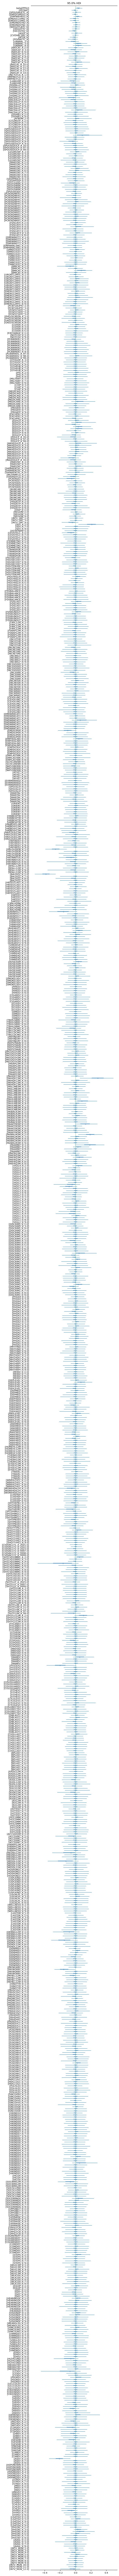

In [13]:
az.plot_forest(idata_sparse, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=False, rope=(0,0), textsize=8);
plt.tight_layout()

In [14]:
cutoff = 0.001
np.abs(summary['mean']).sort_values(ascending=False)[:20].index.values

array(['beta[BALDIZZ_A_2.0]', 'beta[PAIHDFC3M_A_3.0]',
       'beta[HRLOUDJOB_A_2.0]', 'beta[ASEV_A_2.0]', 'beta[SEX_A_2.0]',
       'beta[HYSTEV2_A_2.0]', 'beta[PAIAMNT_A_2.0]',
       'beta[SHTCVD19NM1_A_5.0]', 'beta[PAIWKLM3M_A_2.0]',
       'beta[EARINFECT_A_2.0]', 'beta[PAYWORRY_A_3.0]',
       'beta[DENDL12M_A_2.0]', 'beta[MEDDL12M_A_2.0]',
       'beta[PAIAFFM3M_A_2.0]', 'beta[CFSEV_A_2.0]',
       'beta[SPOUSEDUCP_A_5.0]', 'beta[EMDSUPER_A_2.0]',
       'beta[SHTFLU12M_A_2.0]', 'beta[DENNG12M_A_2.0]',
       'beta[PAIULMB3M_A_3.0]'], dtype=object)

In [15]:
import re
# extract top 20 features but drop duplicates
important = np.abs(summary['mean']).sort_values(ascending=False)[:20].index.values
important_feats = [re.search('\[(.+)_\d+\.0\]',idx).group(1) for idx in important]
# # preserve order
important_feats = list(dict.fromkeys(important_feats)) 
print(important_feats)

pattern = '|'.join(important_feats)
# # filter to keep only relevant features
X_train_new = X_train.filter(regex=pattern)
X_test_new = X_test.filter(regex=pattern)

['BALDIZZ_A', 'PAIHDFC3M_A', 'HRLOUDJOB_A', 'ASEV_A', 'SEX_A', 'HYSTEV2_A', 'PAIAMNT_A', 'SHTCVD19NM1_A', 'PAIWKLM3M_A', 'EARINFECT_A', 'PAYWORRY_A', 'DENDL12M_A', 'MEDDL12M_A', 'PAIAFFM3M_A', 'CFSEV_A', 'SPOUSEDUCP_A', 'EMDSUPER_A', 'SHTFLU12M_A', 'DENNG12M_A', 'PAIULMB3M_A']


In [17]:
summary.to_csv("feature_selection_results_2chains.csv", index=True)